# Relax Inc. Take Home Challenge

In this notebook I will be completing the take home challenge given by Relax Inc. in the PDF accompanying this notebook. My task is to identify "adopted users", defined as those having logged in 3 separate days in a 7-day span, and to identify the factors that predict future user adoption. There are two .csv files with data I can use for this task. Let's dive in!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
users_df = pd.read_csv('takehome_users.csv', encoding='latin-1')
users_df.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0


In [3]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


There are a bunch of missing values for the invited_by_user_id column, likely due to a bunch of people signing up without invites. Let me see if that's true or if some are missing for other reasons:

In [4]:
no_invite = users_df.loc[np.isnan(users_df.invited_by_user_id), :]
no_invite.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
10,11,2013-12-26 03:55:54,Paulsen Malthe,MaltheAPaulsen@gustr.com,SIGNUP,1.388117e+09,0,0,69,NaN
13,14,2012-10-11 16:14:33,Rivera Bret,BretKRivera@gmail.com,SIGNUP,1.350058e+09,0,0,0,NaN


In [5]:
print(no_invite.creation_source.unique())

['SIGNUP' 'PERSONAL_PROJECTS' 'SIGNUP_GOOGLE_AUTH']


In [6]:
invited = users_df.loc[np.isnan(users_df.invited_by_user_id) == False, :]
print(invited.creation_source.unique())

['GUEST_INVITE' 'ORG_INVITE']


As I suspected, the invited id is missing values only where there are non-invited user creation. I don't think we need the ID for this analysis, but instead whether or not the user was invited. So I'll change that column to be a 1/0 categorical variable:

In [7]:
new_id_vals = np.zeros(len(users_df.invited_by_user_id.values), dtype=int)
true_inds = np.where(np.isnan(users_df.invited_by_user_id.values)==False)[0]
new_id_vals[true_inds] = 1
users_df.invited_by_user_id = new_id_vals
users_df.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,1
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,1
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,1


I want to return to this for feature engineering. But before I do that, there's still one more column with NaNs...the last_session_creation_time, which is a UNIX timestamp of the last session creation time. Let's get it into a datetime format and see how things look:

In [8]:
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')
users_df.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,1
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,1


The question here is whether or not to delete the rows with null values in the last session creation time. To figure this out, let's load in and look at the other dataframe.

In [9]:
engagement_df = pd.read_csv('takehome_user_engagement.csv')
engagement_df.head(10)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


In [10]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


For users without last session creations, let's see if they've logged into their accounts at all, and if so, how many times:

In [11]:
users_no_last = users_df.loc[users_df['last_session_creation_time'].isnull(), 'object_id'].values
login_numbers = np.zeros(len(users_no_last))
for ind, user in enumerate(users_no_last):
    login_numbers[ind] = len(engagement_df.loc[engagement_df.user_id == user, 'user_id'].values)
print(np.unique(login_numbers))

[0.]


Ok, so these users never actually logged in. I think that makes it better to delete the null value rows from the dataframe.

In [12]:
users_df.dropna(inplace=True)
users_df.reset_index(drop=True, inplace=True)
users_df.info()
users_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 10 columns):
object_id                     8823 non-null int64
creation_time                 8823 non-null object
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            8823 non-null int64
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 689.4+ KB


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,1
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0
7,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,1
8,11,2013-12-26 03:55:54,Paulsen Malthe,MaltheAPaulsen@gustr.com,SIGNUP,2013-12-27 03:55:54,0,0,69,0
9,13,2014-03-30 16:19:38,Fry Alexander,AlexanderDFry@cuvox.de,ORG_INVITE,2014-03-30 16:19:38,0,0,254,1


Now that all the data is cleaned, we can do some feature engineering. I think two relevant ways to do this would be to get a time difference column between the signup date and last session date, and to get email domains for the users (since emails themselves aren't a useful column on its own). I can also split the creation source column into dummy variables.

In [13]:
# Get the delta time column:
users_df.creation_time = pd.to_datetime(users_df['creation_time'])
users_df['delta_login_time'] = (users_df['last_session_creation_time'] - users_df['creation_time']).dt.days

# Get the creation source dummy variables:
users_df = pd.get_dummies(users_df, columns=['creation_source'], prefix='D_')

users_df.head(10)

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,delta_login_time,D__GUEST_INVITE,D__ORG_INVITE,D__PERSONAL_PROJECTS,D__SIGNUP,D__SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,11,1,0,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,1,1,136,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1,0,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,0,0,1,1,1,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,0,0,193,1,5,1,0,0,0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,2013-12-19 03:37:06,0,0,197,1,2,1,0,0,0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,2012-12-20 13:24:32,0,1,37,0,4,0,0,0,1,0
7,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,2014-06-03 22:08:03,1,1,318,1,503,0,1,0,0,0
8,11,2013-12-26 03:55:54,Paulsen Malthe,MaltheAPaulsen@gustr.com,2013-12-27 03:55:54,0,0,69,0,1,0,0,0,1,0
9,13,2014-03-30 16:19:38,Fry Alexander,AlexanderDFry@cuvox.de,2014-03-30 16:19:38,0,0,254,1,0,0,1,0,0,0


In [14]:
# Get the email domains:
def get_domain(email):
    return email.split('@')[1]

# Create new column with domains:
users_df['email_domain'] = users_df.email.apply(get_domain)

# What are the domains?
domains, counts = np.unique(users_df.email_domain.values, return_counts=True)
print(domains, counts)

['abdnf.com' 'adpql.com' 'aerbd.com' 'aethf.com' 'afzjt.com' 'agfei.com'
 'aiouj.com' 'aipbl.com' 'ajrkw.com' 'akwfl.com' 'aldgv.com' 'amknl.com'
 'amlsi.com' 'anmvu.com' 'anogl.com' 'aosyq.com' 'aotcc.com' 'aotdh.com'
 'apagc.com' 'aqeyf.com' 'arlem.com' 'avfnw.com' 'bawmq.com' 'bbdkr.com'
 'bchfd.com' 'bdlvv.com' 'bdnfn.com' 'beszv.com' 'bfukq.com' 'bfvoj.com'
 'bfxyd.com' 'bgdtm.com' 'bgdut.com' 'bgdwc.com' 'bhisp.com' 'bhjwj.com'
 'bikch.com' 'biljj.com' 'binqn.com' 'bosvd.com' 'bqdse.com' 'breuo.com'
 'brhlk.com' 'bsjsm.com' 'bsmgs.com' 'bsmic.com' 'btoph.com' 'btpuf.com'
 'btrfw.com' 'btsil.com' 'bttmc.com' 'btusf.com' 'bvcwd.com' 'bxlng.com'
 'bztur.com' 'bztuu.com' 'cavde.com' 'cbxln.com' 'cbype.com' 'cbyst.com'
 'cceoj.com' 'cdhew.com' 'ceneg.com' 'ceoiv.com' 'ceqro.com' 'cfqpe.com'
 'cgbld.com' 'chcor.com' 'chdsg.com' 'cjpwo.com' 'cjpwq.com' 'cksld.com'
 'ckuun.com' 'ckvbo.com' 'clbuw.com' 'clwdx.com' 'cmbwg.com' 'cmhvk.com'
 'cnkkt.com' 'copkb.com' 'cpvie.com' 'crcly.com' 'c

In [15]:
# Top domains?
most_common_domains = domains[np.where(counts > 2)]
print(most_common_domains)

['cuvox.de' 'gmail.com' 'gustr.com' 'hotmail.com' 'jourrapide.com'
 'yahoo.com']


In [16]:
def fix_domains(domain):
    if domain in ['cuvox.de', 'gmail.com', 'gustr.com', 'hotmail.com', 'jourrapide.com', 'yahoo.com']:
        return domain
    else:
        return 'other'

users_df.email_domain = users_df.email_domain.apply(fix_domains)
users_df = pd.get_dummies(users_df, columns=['email_domain'], prefix='D_')
users_df.head(10)

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,delta_login_time,...,D__PERSONAL_PROJECTS,D__SIGNUP,D__SIGNUP_GOOGLE_AUTH,D__cuvox.de,D__gmail.com,D__gustr.com,D__hotmail.com,D__jourrapide.com,D__other,D__yahoo.com
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,11,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,1,1,136,...,0,0,0,0,0,1,0,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,0,0,193,1,5,...,0,0,0,0,0,0,0,0,0,1
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,2013-12-19 03:37:06,0,0,197,1,2,...,0,0,0,0,0,0,0,0,0,1
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,2012-12-20 13:24:32,0,1,37,0,4,...,0,1,0,0,0,0,0,1,0,0
7,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,2014-06-03 22:08:03,1,1,318,1,503,...,0,0,0,0,0,1,0,0,0,0
8,11,2013-12-26 03:55:54,Paulsen Malthe,MaltheAPaulsen@gustr.com,2013-12-27 03:55:54,0,0,69,0,1,...,0,1,0,0,0,1,0,0,0,0
9,13,2014-03-30 16:19:38,Fry Alexander,AlexanderDFry@cuvox.de,2014-03-30 16:19:38,0,0,254,1,0,...,0,0,0,1,0,0,0,0,0,0


I now have all of the features I'd like. Now I just need the target variable, which is whether or not a user is an "adopted user." This can be done with the engagement dataframe:

In [17]:
users = users_df['object_id'].values
engagement_df.time_stamp = pd.to_datetime(engagement_df.time_stamp)
adopted = np.zeros(len(users), dtype=int)
for ind, user in enumerate(users):
    login_stamps = engagement_df.loc[engagement_df.user_id==user, 'time_stamp'].values
    if len(login_stamps) < 3:
        continue
    else:
        for i in range(2, len(login_stamps)):
            # The difference in times here are given in nanoseconds, so I convert to days
            if int(login_stamps[i] - login_stamps[i-2])/8.64e13 < 7:
                adopted[ind] = 1
                break
print(sum(adopted), np.mean(adopted))

1602 0.18157089425365522


Ok, now we have our target variable: there are 1602 adopted users, which represents 18.2% of the dataset, so our dataset is imbalanced. We will worry about that later. Let's first just look at correlations with the different variables and the target variable. This will help us to get an idea of how these features individually predict (or not) the users will become adopted users. I will begin with the Pearson Correlation coefficient:

In [18]:
from scipy.stats import pearsonr

X = users_df.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 'org_id'], axis=1)
y = adopted

corr_df = pd.DataFrame(X.columns, columns=['Feature'])
r_vals = np.zeros(len(corr_df.Feature.values))
p_vals = r_vals.copy()

for i, feature in enumerate(corr_df.Feature.values):
    r_vals[i], p_vals[i] = pearsonr(X[feature].values, y)
corr_df['r_vals'] = r_vals
corr_df['p_vals'] = p_vals

In [19]:
corr_df

,Feature,r_vals,p_vals
0,opted_in_to_mailing_list,0.006650,5.322785e-01
1,enabled_for_marketing_drip,0.002058,8.467083e-01
2,invited_by_user_id,0.027034,1.110187e-02
3,delta_login_time,0.787326,0.000000e+00
4,D__GUEST_INVITE,0.054847,2.536882e-07
5,D__ORG_INVITE,-0.015820,1.373132e-01
6,D__PERSONAL_PROJECTS,0.026429,1.304503e-02
7,D__SIGNUP,-0.036937,5.200745e-04
8,D__SIGNUP_GOOGLE_AUTH,-0.015741,1.392937e-01
9,D__cuvox.de,-0.012442,2.425656e-01


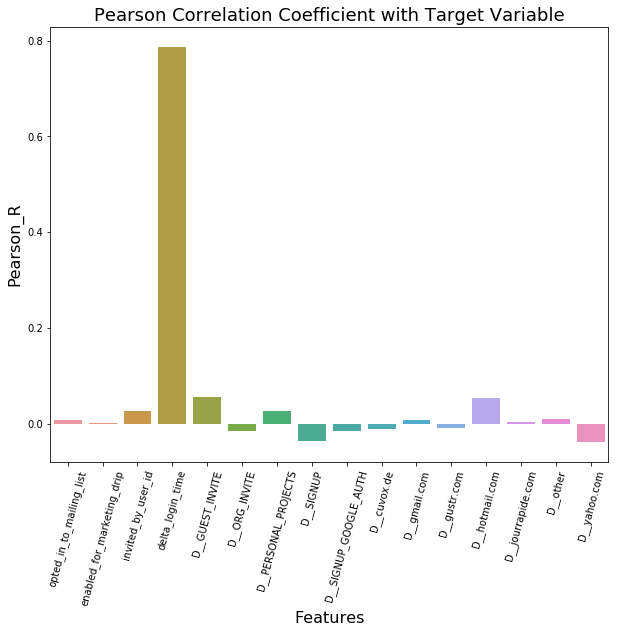

In [20]:
fig, axes = plt.subplots(figsize=(10,8))
sns.barplot(x='Feature', y='r_vals', data=corr_df)
_ = axes.set_title('Pearson Correlation Coefficient with Target Variable', fontsize=18)
_ = axes.set_xlabel('Features', fontsize=16)
_ = axes.set_ylabel('Pearson_R', fontsize=16)
plt.xticks(rotation=75)
plt.show()

The above bar graph shows the relative strengths of each feature, measured via the pearson correlation coefficient. I find that the strongest feature is the delta_login_time, which implies that the longer a user utilizes the service, the more likely they are to become an adopted user, which very much makes sense. Other strong correlations are seen in the D_GUEST_INVITE and D_hotmail.com features, meaning there could be a relationship with those who join the service via an invitation, and those who use hotmail accounts for their emails. Though not shown on the figure, these correlations all have p values less than 0.05, and are thus statistically significant.

While this information is valuable to understand these relationships, the pearson correlation coefficient is less relevant when you have two categorical variables to compare. As such, I will use a different measure, called Cramer's V, to understand the association between the features and the target variable. Like the Pearson correlation coefficient, Cramer's V is symmetric, though it ranges from 0 to 1 (0 being no association and 1 being a strong association, either positive or negative). 

In [23]:
import scipy.stats as st

def cramers_v(x, y):
    
    confusion_matrix = pd.crosstab(x,y)
    chi2 = st.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

In [25]:
cr_vals = np.zeros(len(corr_df.Feature.values))
#p_vals = r_vals.copy()

for i, feature in enumerate(corr_df.Feature.values):
    cr_vals[i] = cramers_v(X[feature].values, y)
corr_df['cramer_vals'] = cr_vals

In [26]:
corr_df

,Feature,r_vals,p_vals,cramer_vals
0,opted_in_to_mailing_list,0.006650,5.322785e-01,0.000000
1,enabled_for_marketing_drip,0.002058,8.467083e-01,0.000000
2,invited_by_user_id,0.027034,1.110187e-02,0.024530
3,delta_login_time,0.787326,0.000000e+00,0.888730
4,D__GUEST_INVITE,0.054847,2.536882e-07,0.053416
5,D__ORG_INVITE,-0.015820,1.373132e-01,0.011285
6,D__PERSONAL_PROJECTS,0.026429,1.304503e-02,0.023618
7,D__SIGNUP,-0.036937,5.200745e-04,0.034997
8,D__SIGNUP_GOOGLE_AUTH,-0.015741,1.392937e-01,0.011040
9,D__cuvox.de,-0.012442,2.425656e-01,0.005401


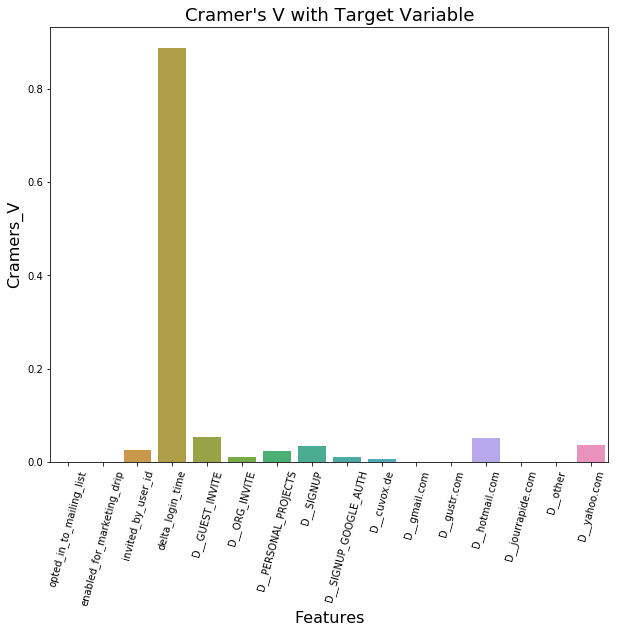

In [27]:
fig, axes = plt.subplots(figsize=(10,8))
sns.barplot(x='Feature', y='cramer_vals', data=corr_df)
_ = axes.set_title("Cramer's V with Target Variable", fontsize=18)
_ = axes.set_xlabel('Features', fontsize=16)
_ = axes.set_ylabel('Cramers_V', fontsize=16)
plt.xticks(rotation=75)
plt.show()

Here we can see that the values for the Cramer's V is similar to that of the Pearson R, though positive or zero for all features. Here it's important to look at the categorical variables, and we can see that the relationships seen previously seem to be similar here. As a third statistical measure, I will use the correlation ratio, which is used for comparing a continuous variable with a categorical one. This is to double-check on the delta_login_time association with adopted users.

In [28]:
def correlation_ratio(categories, measurements):
    
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg), 2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator / denominator
    return eta

In [29]:
corr_vals = np.zeros(len(corr_df.Feature.values))
#p_vals = r_vals.copy()

for i, feature in enumerate(corr_df.Feature.values):
    corr_vals[i] = correlation_ratio(X[feature].values, y)
corr_df['correlation_ratio_vals'] = corr_vals

In [30]:
corr_df

,Feature,r_vals,p_vals,cramer_vals,correlation_ratio_vals
0,opted_in_to_mailing_list,0.006650,5.322785e-01,0.000000,0.000044
1,enabled_for_marketing_drip,0.002058,8.467083e-01,0.000000,0.000004
2,invited_by_user_id,0.027034,1.110187e-02,0.024530,0.000731
3,delta_login_time,0.787326,0.000000e+00,0.888730,0.847675
4,D__GUEST_INVITE,0.054847,2.536882e-07,0.053416,0.003008
5,D__ORG_INVITE,-0.015820,1.373132e-01,0.011285,0.000250
6,D__PERSONAL_PROJECTS,0.026429,1.304503e-02,0.023618,0.000698
7,D__SIGNUP,-0.036937,5.200745e-04,0.034997,0.001364
8,D__SIGNUP_GOOGLE_AUTH,-0.015741,1.392937e-01,0.011040,0.000248
9,D__cuvox.de,-0.012442,2.425656e-01,0.005401,0.000155


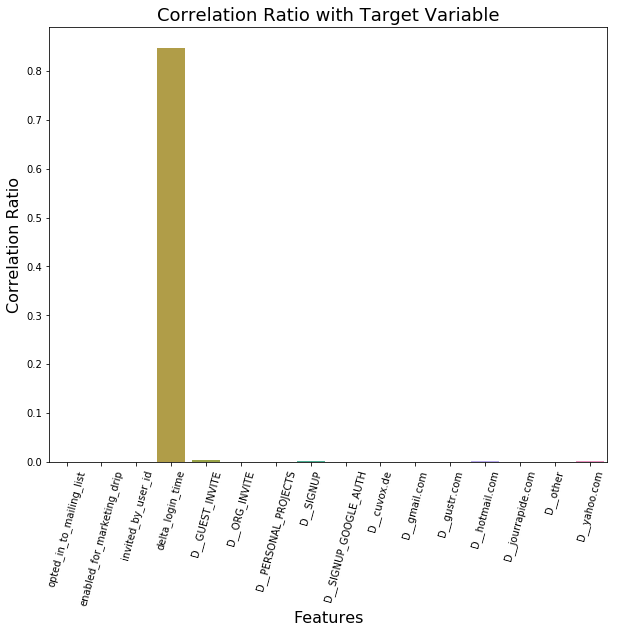

In [31]:
fig, axes = plt.subplots(figsize=(10,8))
sns.barplot(x='Feature', y='correlation_ratio_vals', data=corr_df)
_ = axes.set_title("Correlation Ratio with Target Variable", fontsize=18)
_ = axes.set_xlabel('Features', fontsize=16)
_ = axes.set_ylabel('Correlation Ratio', fontsize=16)
plt.xticks(rotation=75)
plt.show()

This helps confirm the strong association there is between the delta_login_time and the prediction of adopted viewers. It is likely that this is the strongest feature, and I would recommend that this service help retain users long term in order to increase their adoptive users.

This is just one way to look at feature improtances, and ideally I would like to perform additional analysis, as these measures look at the effects of features individually on the target variable, but does not look into any collective effects of the features together on the target. To do that more complex analysis, I would need to do some predictive modeling with machine learning algorithms. Different analyses can showcase different relationships, and so multiple methods would be good for use, such as logistic regression, random forest, and a neural network, to name a few. In order to carry out this analysis, I would also want to look into any possible correlations between the features themselves for colinearity, which could lead to modeling problems. Given that only 18.2% of users are adopted users, I would also want to balance the dataset before using these algorithms, perhaps via resampling.

Given the time constraints of this challenge, and the recommendation of only spending 1-2 hours on this analysis, I leave the rest to future work.